# Historical Data: Intraday

These financial data are generally provided in a format that includes the following information:  
Date  
Open Price  
High Price  
Low Price  
Closing Price  
Volume
These data—often referred to as OHLC Chart Data—can be interpreted as Time Series data and are perfect for performing technical analysis. We’ll dive into this format in just a moment but, for now, just realize this is a standard format for historical pricing data within financial markets.

## Import libraries

In [207]:
import yfinance as yf
import os
import pandas as pd
from matplotlib import pyplot as plt
from io import StringIO
import requests
import seaborn as sns
import numpy as np

## Extracting ticker codes
Extracting ticker codes of yfinance and EODhistoricaldata of same companies.

In [6]:
'''Extracting ticker of eodhistoricaldata.'''
api_key = os.environ['EOD_API_KEY']

class NoSuchExchange(Exception):
    def __init__(self, message: str= "No such exhange supported."):
        self.message = message
        super().__init__(message)

def get_ticker_list(exchange, api_token, session=None):
    """Returns a df of tickers available in EODhistorical data."""
    if exchange not in ['BSE', 'NSE']:
        raise NoSuchExchange()
    
    if session is None:
        session=requests.Session()
        url = 'https://eodhistoricaldata.com/api/exchange-symbol-list/%s' % exchange
        params = {'api_token': api_token}
        r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df

In [15]:
file = 'Yahoo Ticker Symbols - September 2017.xlsx'                                             #file that contains ticker list of yfinance.
df = pd.read_excel(os.path.abspath(file), sheet_name='Stock')
ticker_list1 = get_ticker_list('BSE', api_key)                                                  #extracting BSE tickers from EOD ticker list.
name_list=ticker_list1['Name']
df_BSE = df[df['Unnamed: 2'] == 'BSE']                                                          #extracting BSE tickers from yfinance ticker list.
ticker = df_BSE[df_BSE['Unnamed: 1'].isin(name_list)].head(30)                                  # filtering common companies in both ticker lists.
extra_name = ticker_list1[ticker_list1['Name'].isin(ticker['Unnamed: 1'])].reset_index()        
yfinance_ticker = ticker['Yahoo Stock Tickers'].reset_index(drop=True)                          # getting ticker codes of common companies of yfinance.
yfinance_company = ticker['Unnamed: 1'].reset_index(drop=True)                                  # getting company name of common companies of yfinance.
eod_ticker = extra_name['Code'].reset_index(drop=True)                                          # getting ticker codes of common companies of eodhistoricaldata.
eod_company = extra_name['Name'].reset_index(drop=True)                                         # getting company names of common companies of eodhistoricaldata.

## Download yfinance historical data

In [16]:
# download historical data of yfinance
yfinance_dict = {}
for i in range(30):
    yfinance_dict[yfinance_company[i]] = yf.download(yfinance_ticker[i], period='max')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Extract EODHistoricaldata

In [11]:
def get_eod_data(symbol, api_token="xxxx", session=None):
    '''returns a df of historical data.'''
    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        params = {"api_token": api_token}
        r = session.get(url, params=params)

    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df


api_key = api_key = os.environ['EOD_API_KEY']
eod_dict = {}
for i in range(29):
    eod_dict[eod_company[i]] = get_eod_data(eod_ticker[i]+'.BSE', api_key)


## Data Preprocessing
Checking is data contains null, duplicate values or not and data contains any outliers or not.

In [1]:
# Checking if data contains any outliers
def find_outliers(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return pd.DataFrame(outliers)

def data_preprocessing(df):
   """Returns a dictionary with the keys:
      null_values: the number of cells which contains null values.
      duplicated_values: the number of cells which contain duplicate values.
      commont_stats: describe the data like mean, median, max, min
      outliers: the no. of outliers data contains and min amd max outlier in particular field.
   """

   null_values = df.isna().sum()                      # checking if data contains any null values
   duplicate_values = df.duplicated()                 # checking if data contains any duplicate values
   common_stats = df.describe()                       # checking common stats of data
   outliers = find_outliers(df)                       # finding outliers in data

   dict = {'null_values':null_values, 'duplicate_values':duplicate_values, 'common_stats':common_stats, 'outliers':outliers}
   return dict

In [383]:
"""Checking EOD and yfinance Data. """
data_preprocessing_eod = {}
data_preprocessing_yfinance = {}
for company in eod_dict.keys():
    data_preprocessing_eod[company] = data_preprocessing(eod_dict[company])
    data_preprocessing_yfinance[company] = data_preprocessing(yfinance_dict[company])

In [ ]:
data_preprocessing_eod

In [ ]:
data_preprocessing_yfinance

## Data wrangling
Finding differences in data and combining open, close, high, low and volume values of different companies together.

In [89]:
def data_convert(dict):
    """Returns a list of dataframes with yearly calculated stock data of different companies together of different fields."""
    data = {}
    for company in eod_company:
        try:
            data[company] = dict[company]
            data[company]['date'] = pd.to_datetime(data[company].index)
            data[company].set_index('date', inplace=True)
            data[company].index = pd.to_datetime(data[company].index)
            data[company] = data[company].resample('A').last()
        except KeyError as e:
            pass

    res = pd.concat(data.values(), axis=1, keys=data.keys())

    open = {}
    close = {}
    high = {}
    low = {}
    volume = {}
    for company in data.keys():
        open[company] = res[company]['Open']
        close[company] = res[company]['Close']
        high[company] = res[company]['High']
        low[company] = res[company]['Low']
        volume[company] = res[company]['Volume']

    res_open = pd.DataFrame(open)
    res_close = pd.DataFrame(close)
    res_high = pd.DataFrame(high)
    res_low = pd.DataFrame(low)
    res_volume = pd.DataFrame(volume)

    return [res_open, res_close, res_high, res_low, res_volume]

In [104]:
eod_list = data_convert(eod_dict)
yfinance_list=data_convert(yfinance_dict)
difference_in_data = {}
for company in eod_dict.keys():
    difference_in_data[company] = eod_dict[company] - yfinance_dict[company]

difference_in_data_list = data_convert(difference_in_data)

## Ploting the data
Let's plot the difference in the values of data provided by yfinance and EODhistorical of 30 companies.

### Boxplot

#### Boxplot of Eodhistorical data
Boxplot of EODhistorical data of 30 companies values on yearly basis.

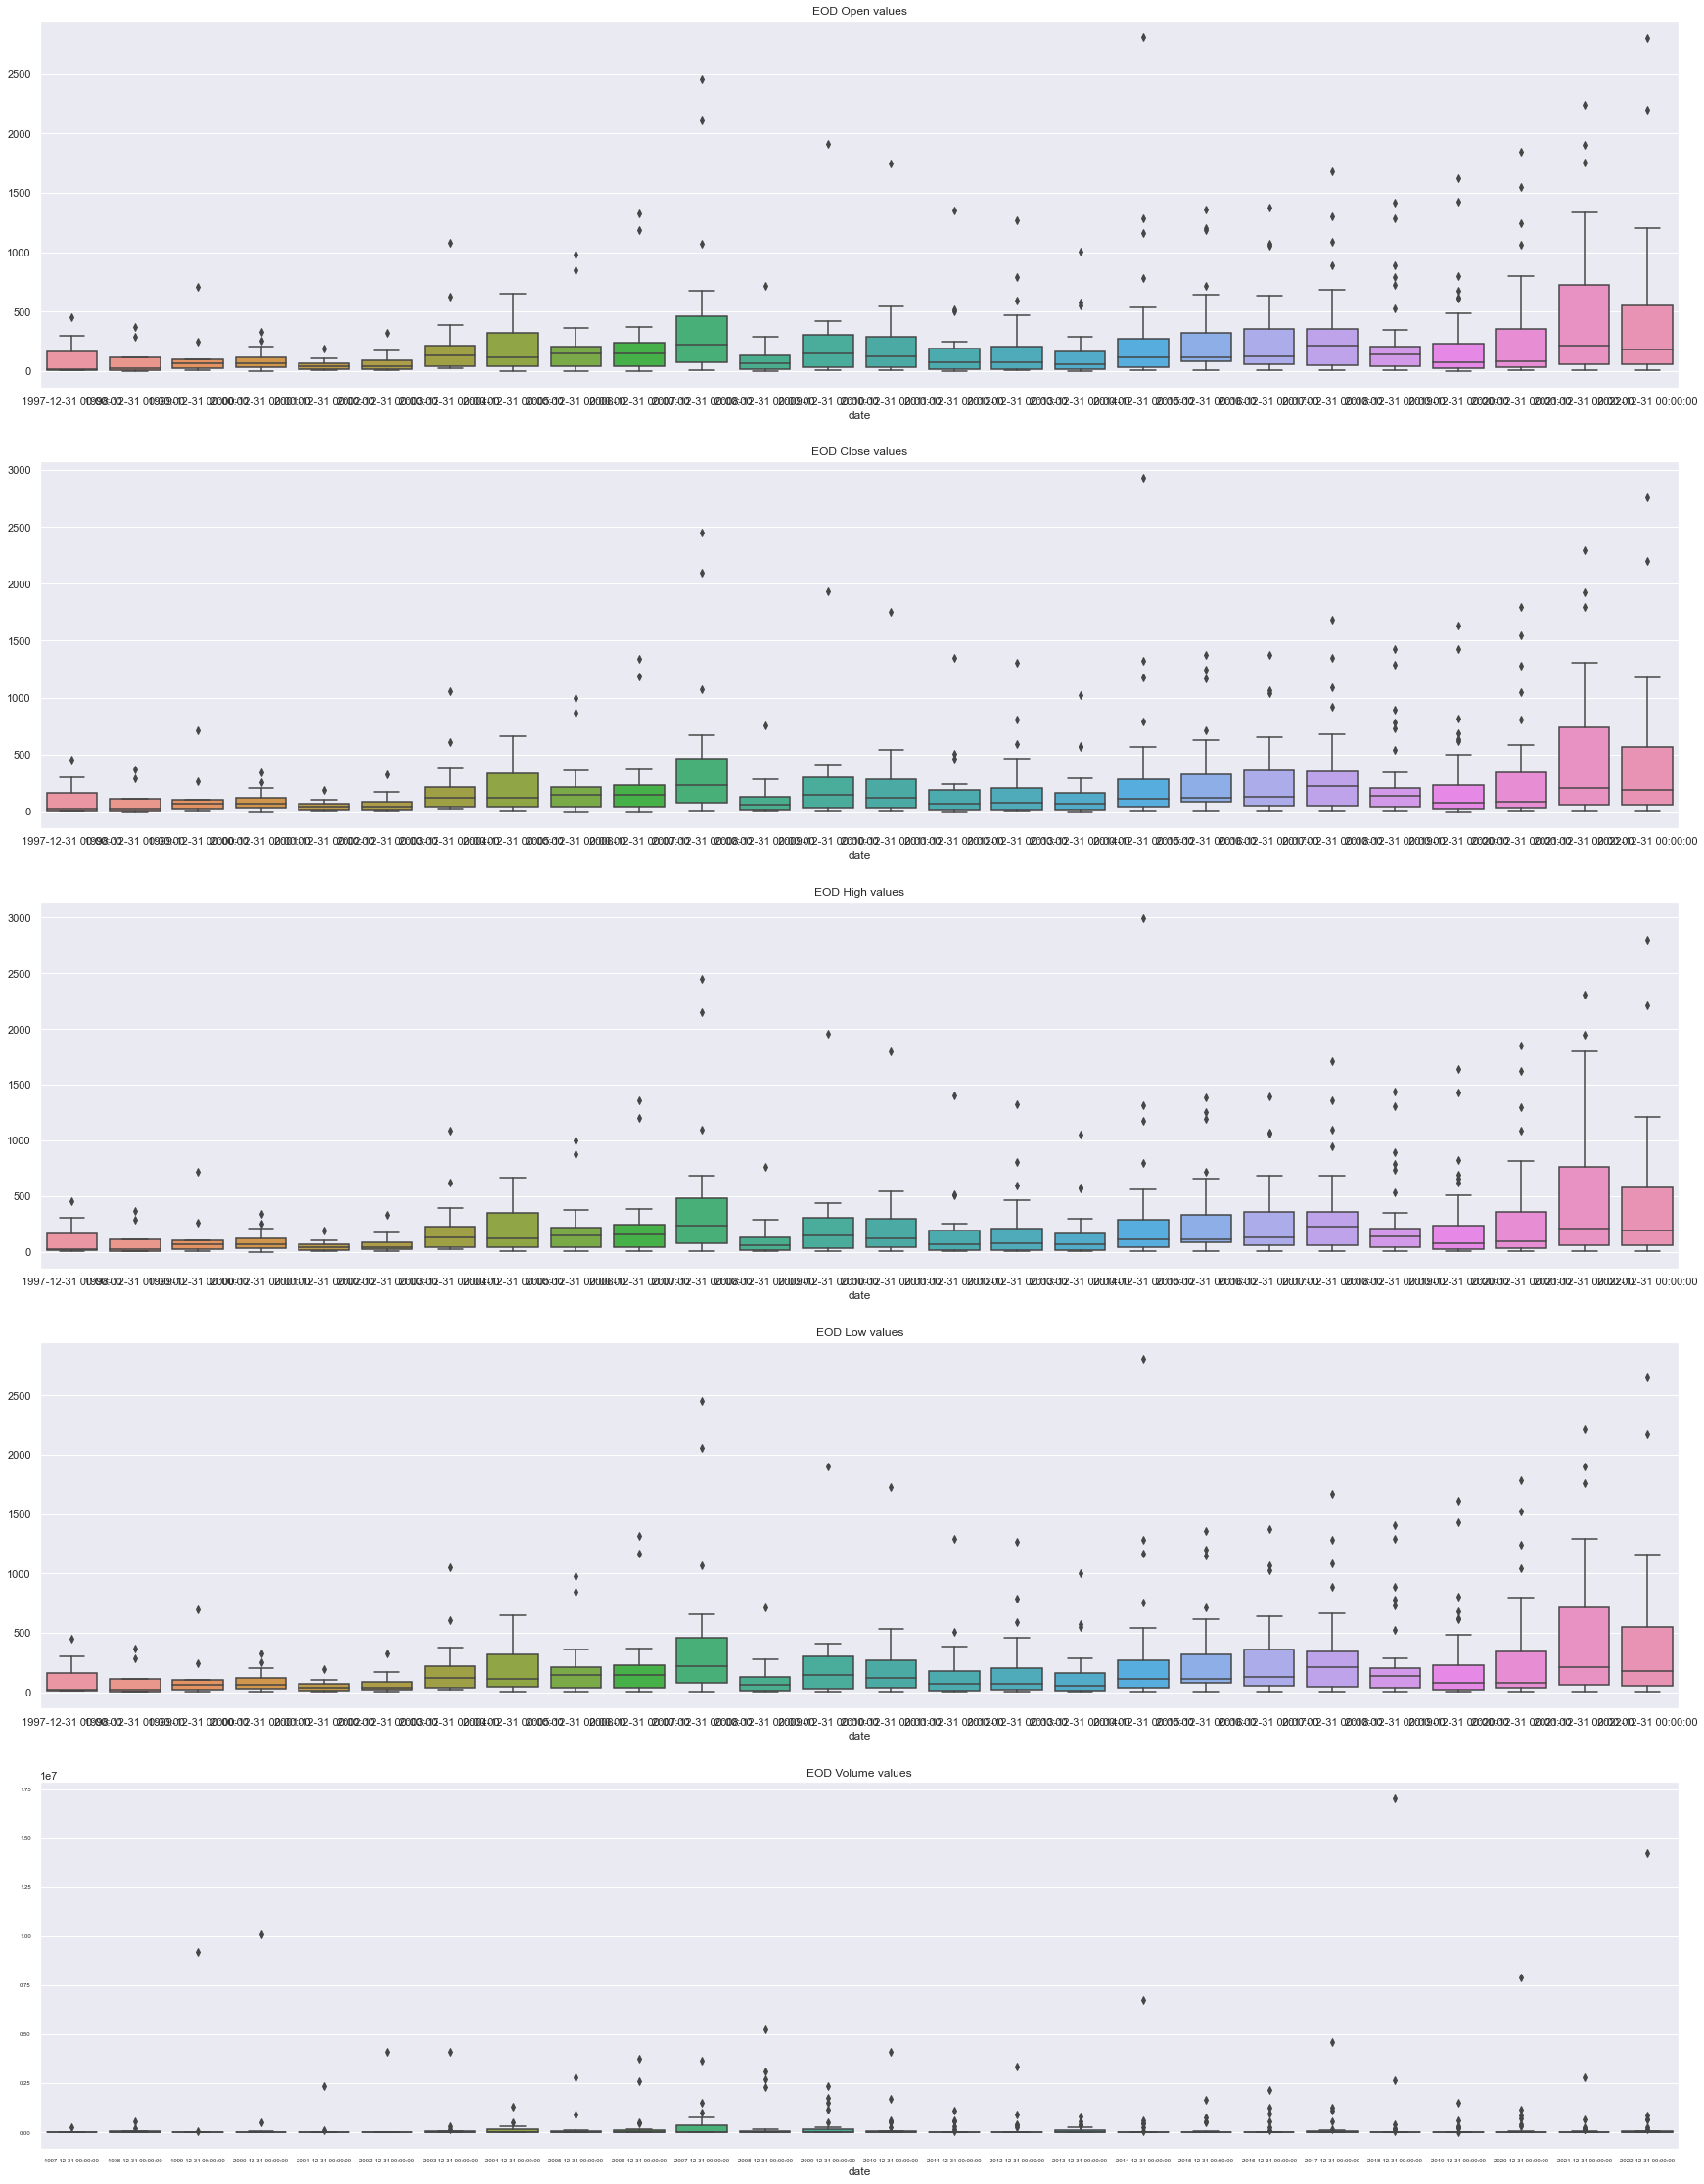

In [ ]:
f, axes = plt.subplots(5, figsize = (30,40))

sns.boxplot(data=eod_list[0].T, ax=axes[0]).set(title='EOD Open values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=eod_list[1].T, ax=axes[1]).set(title='EOD Close values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=eod_list[2].T, ax=axes[2]).set(title='EOD High values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=eod_list[3].T, ax=axes[3]).set(title='EOD Low values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=eod_list[4].T, ax=axes[4]).set(title='EOD Volume values')
plt.tick_params(axis='both', which='major', labelsize=6)

#### Boxplot of Yfinance data
Boxplot of Yfinance data of 30 companies values on yearly basis.

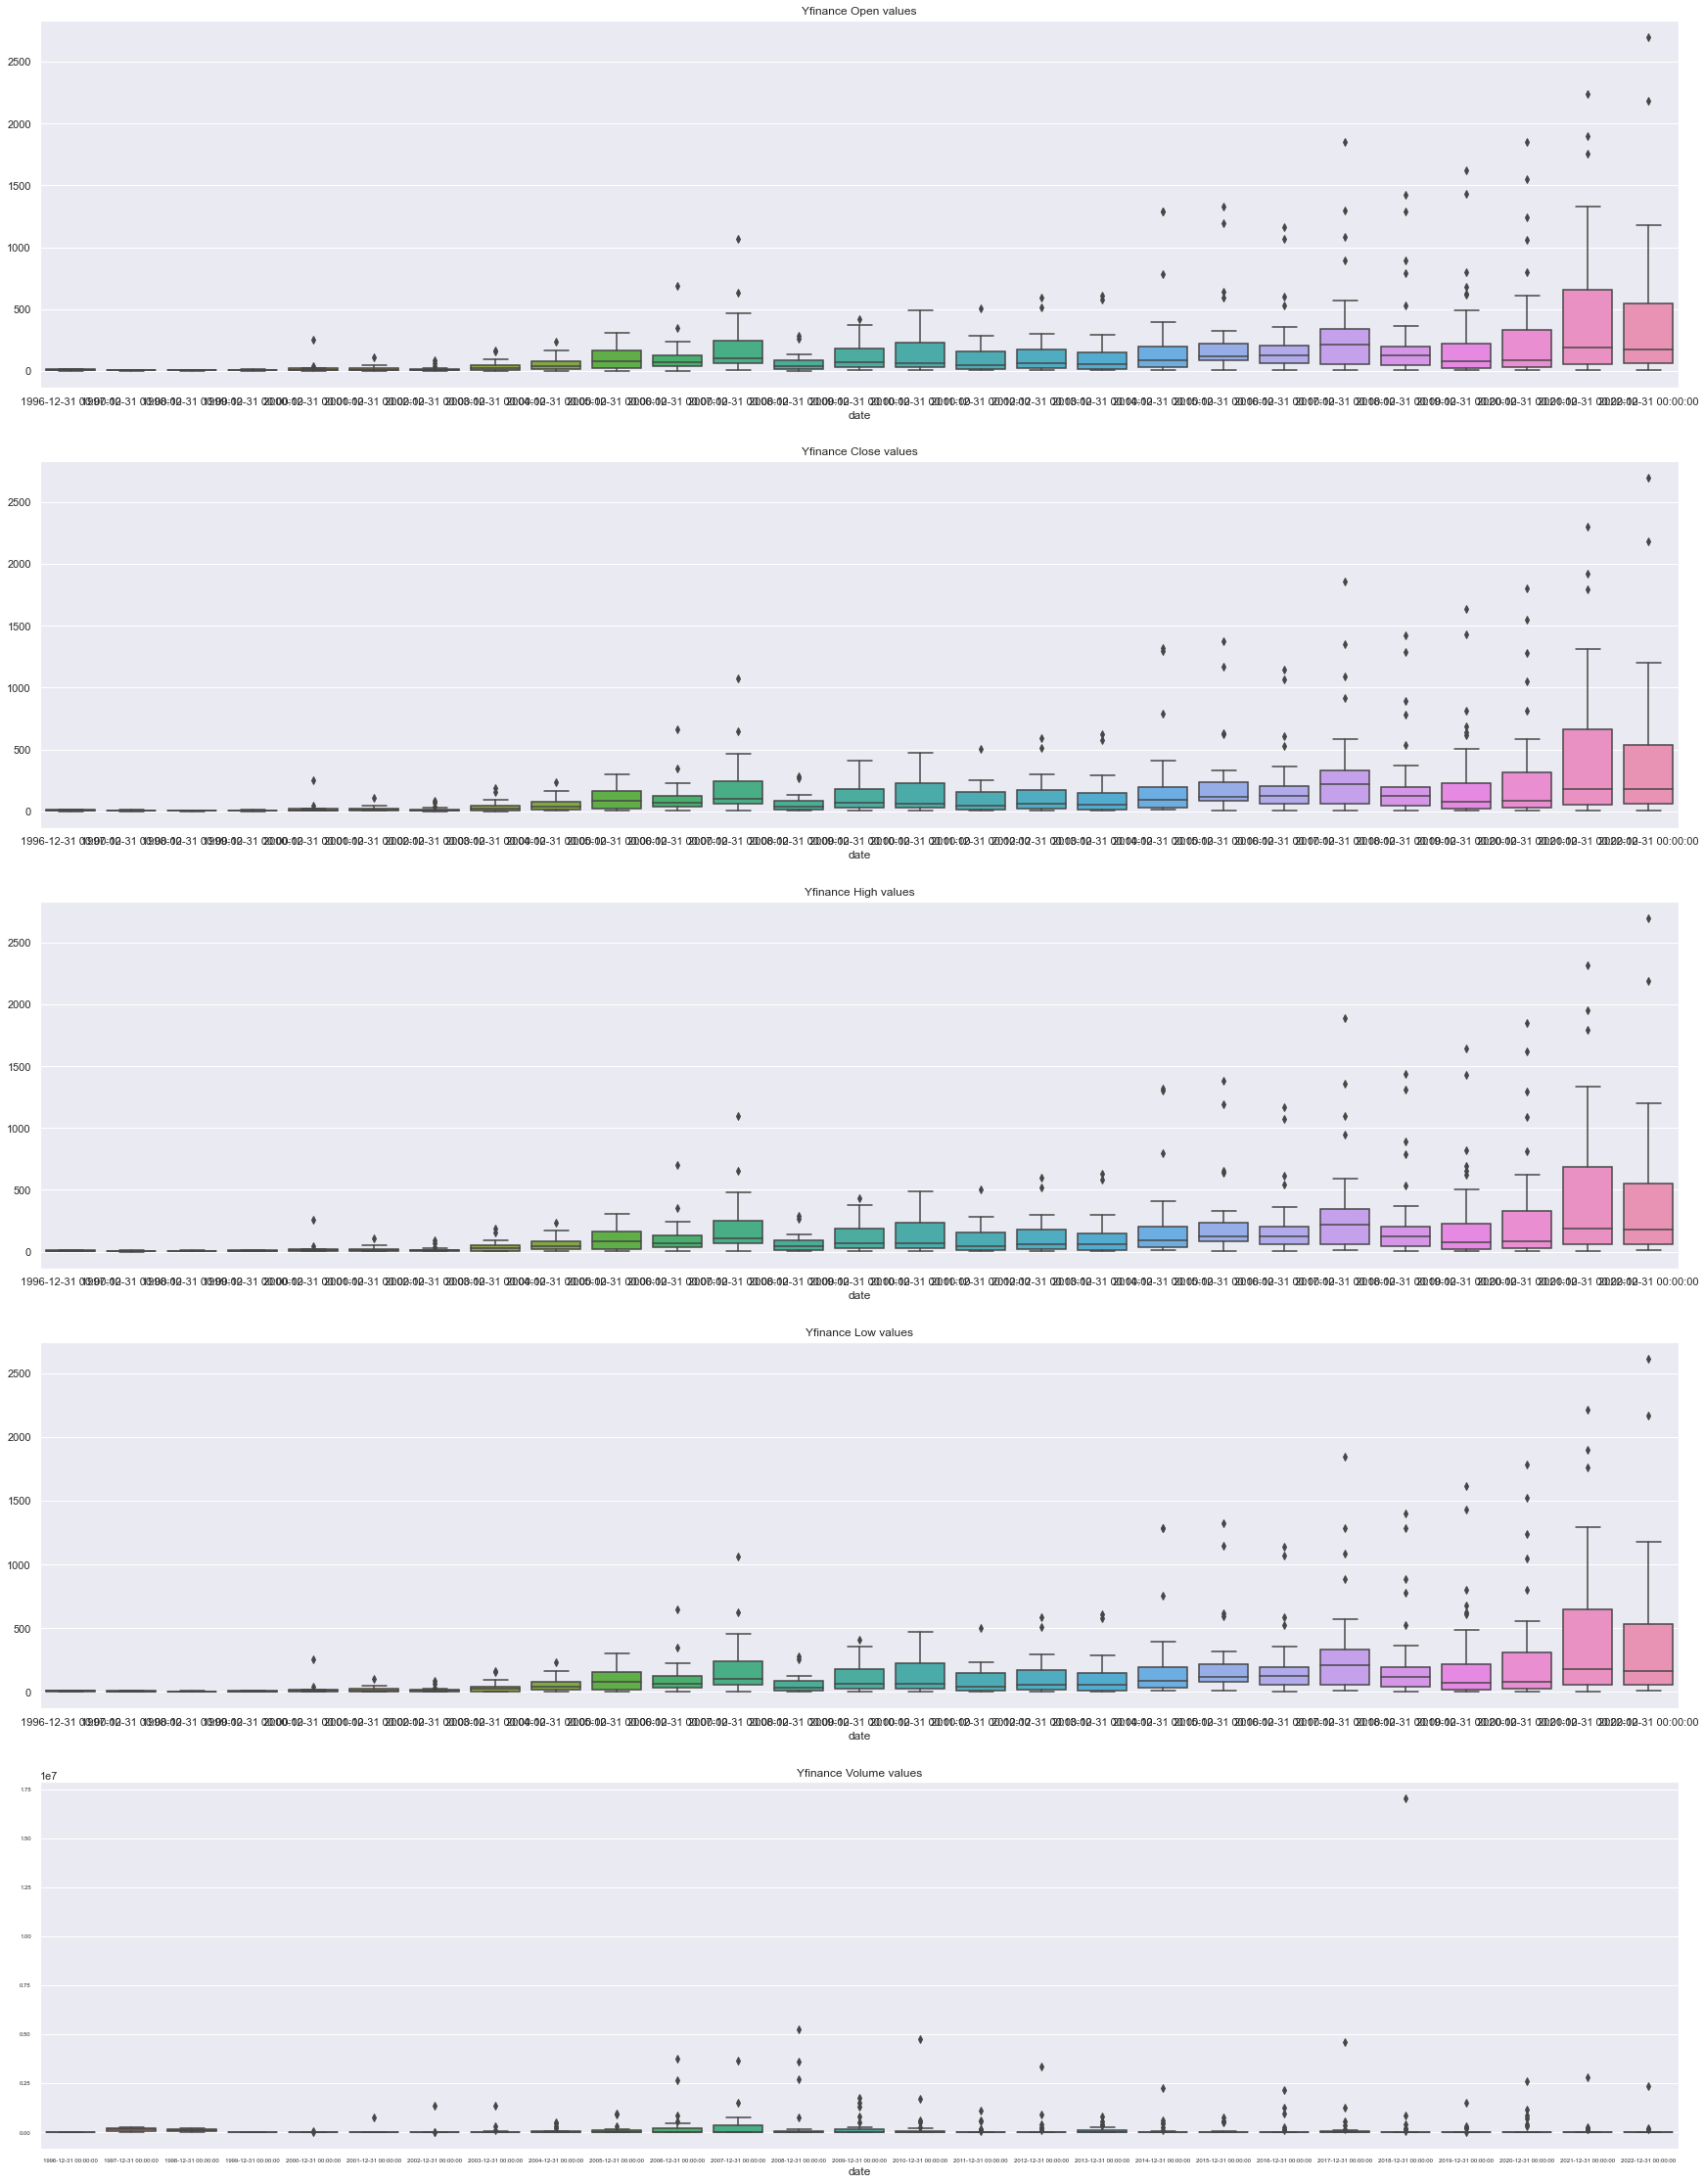

In [ ]:
f, axes = plt.subplots(5, figsize = (30,40))

sns.boxplot(data=yfinance_list[0].T, ax=axes[0]).set(title='Yfinance Open values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=yfinance_list[1].T, ax=axes[1]).set(title='Yfinance Close values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=yfinance_list[2].T, ax=axes[2]).set(title='Yfinance High values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=yfinance_list[3].T, ax=axes[3]).set(title='Yfinance Low values')
plt.tick_params(axis='both', which='major', labelsize=6)
sns.boxplot(data=yfinance_list[4].T, ax=axes[4]).set(title='Yfinance Volume values')
plt.tick_params(axis='both', which='major', labelsize=6)

### Heatmap
Heatmap of open, close, low, high and volume of 30 companies of yearly data of difference in the values in the data provided by the eodhistoricaldata and yfinance.

#### Heatmap of Open values

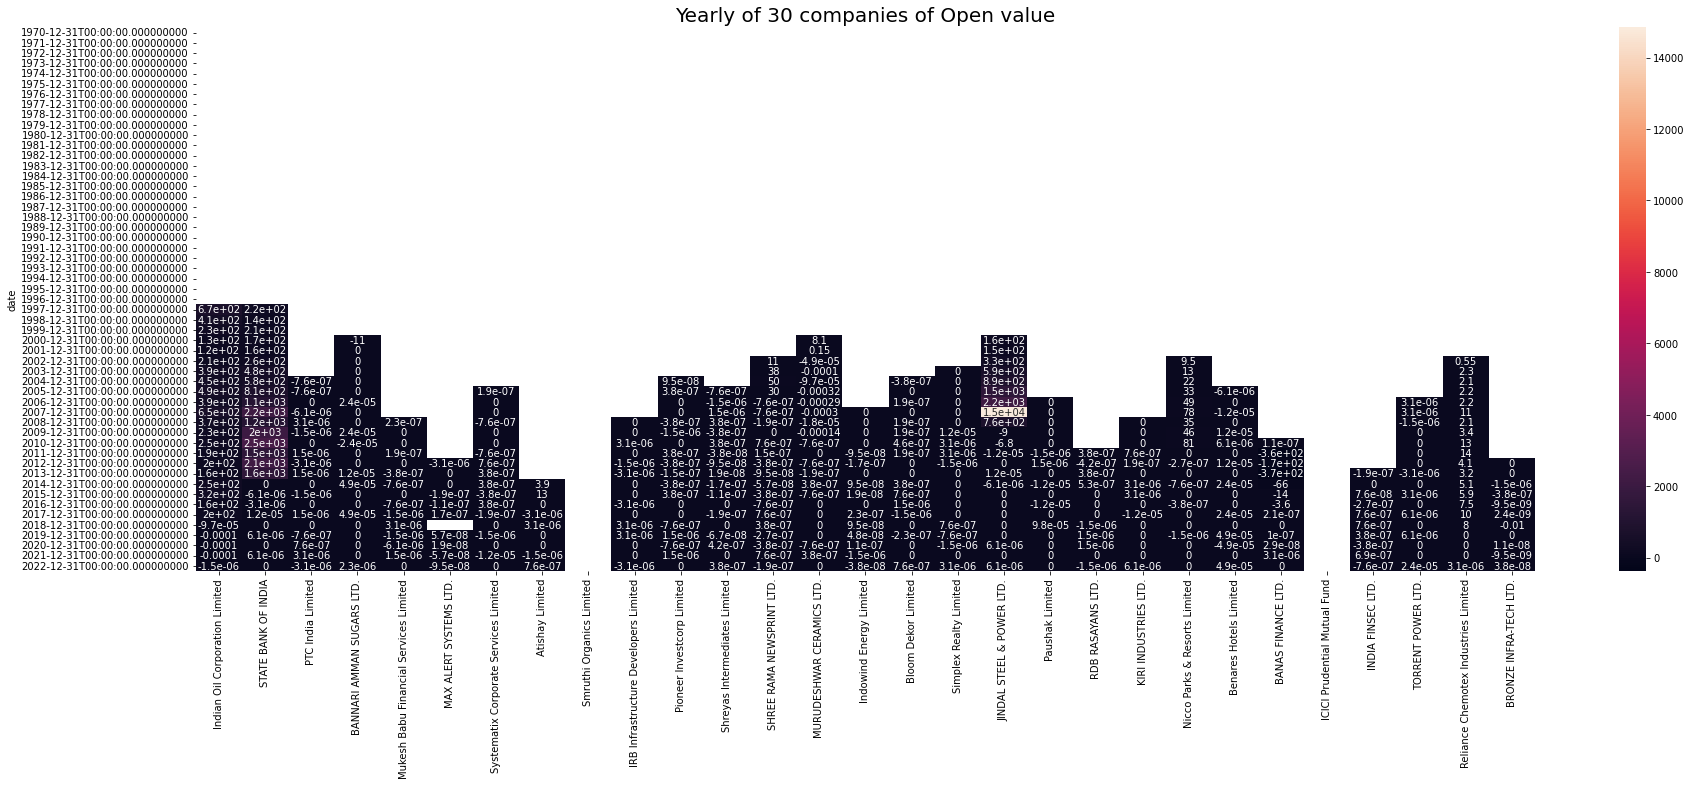

In [358]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[0] , annot = True)
plt.title('Yearly of 30 companies of Open value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Close values

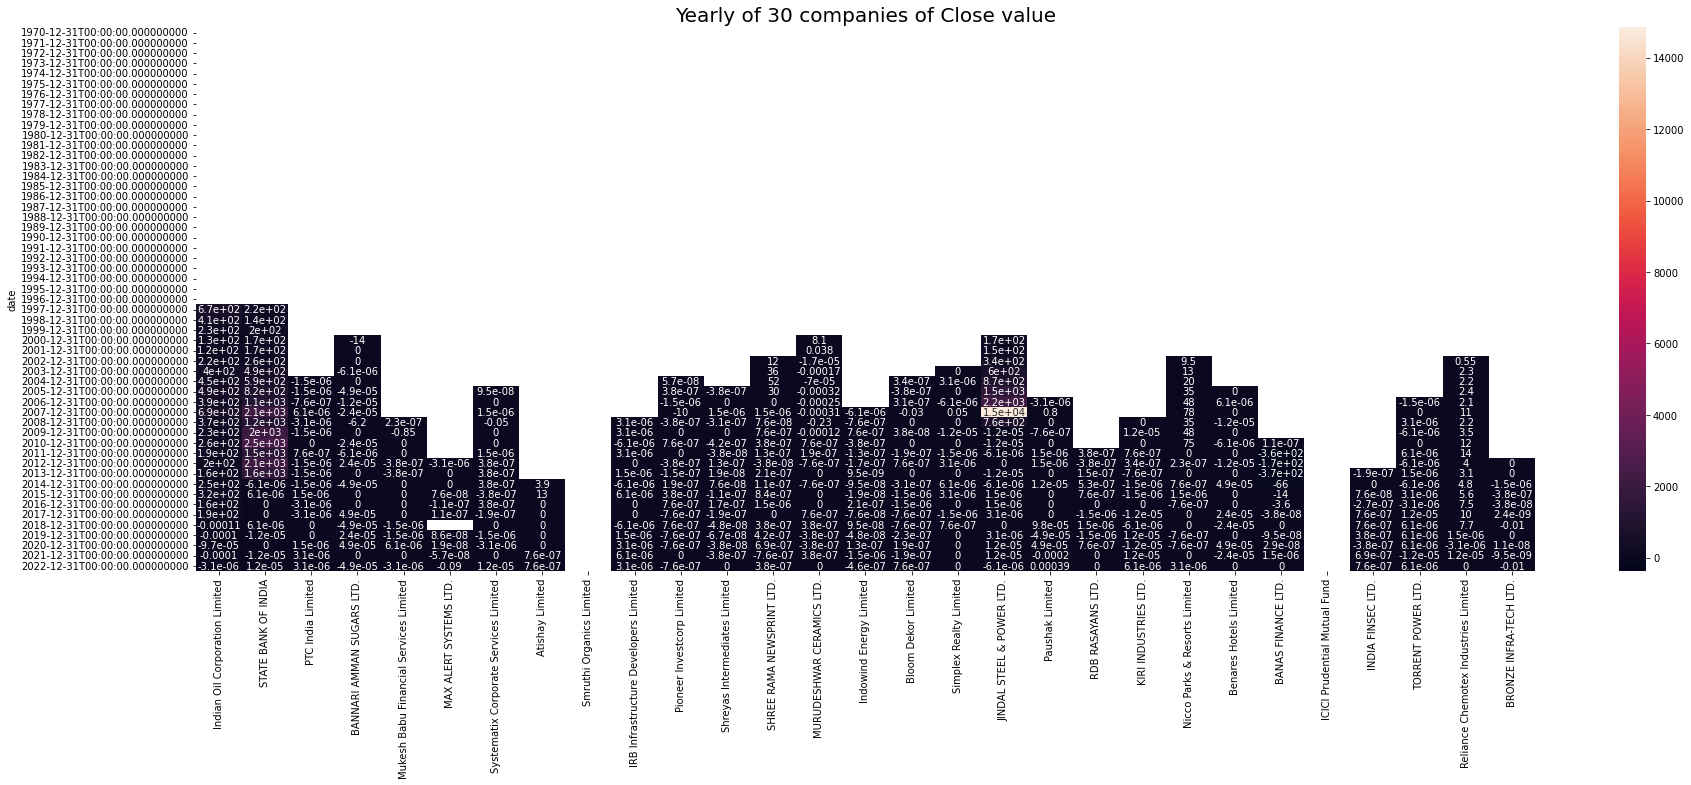

In [361]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[1] , annot = True)
plt.title('Yearly of 30 companies of Close value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of High values

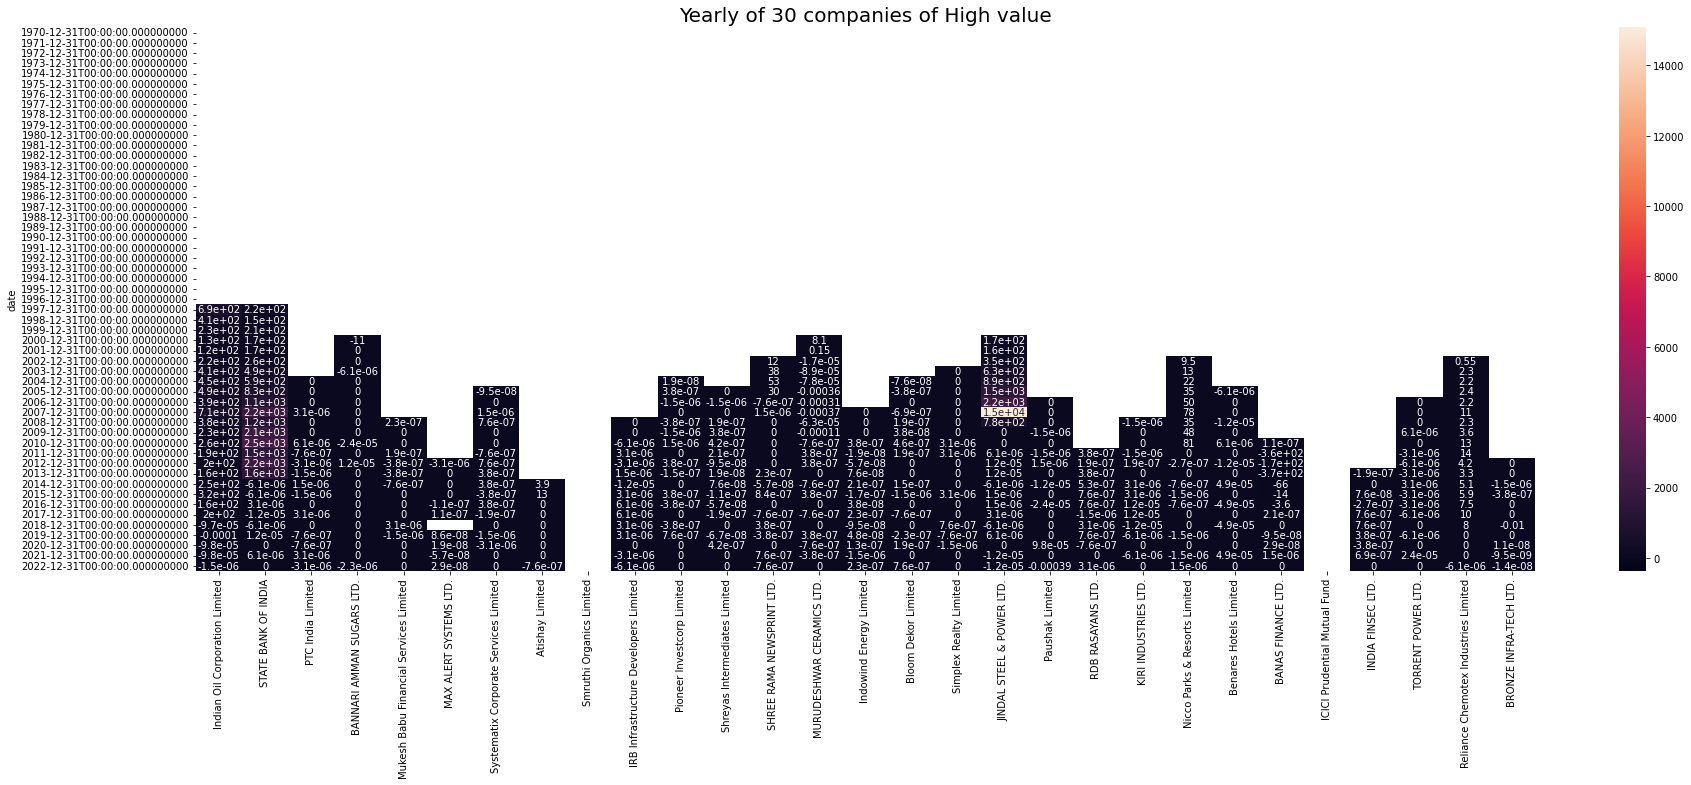

In [359]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[2] , annot = True)
plt.title('Yearly of 30 companies of High value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Low values

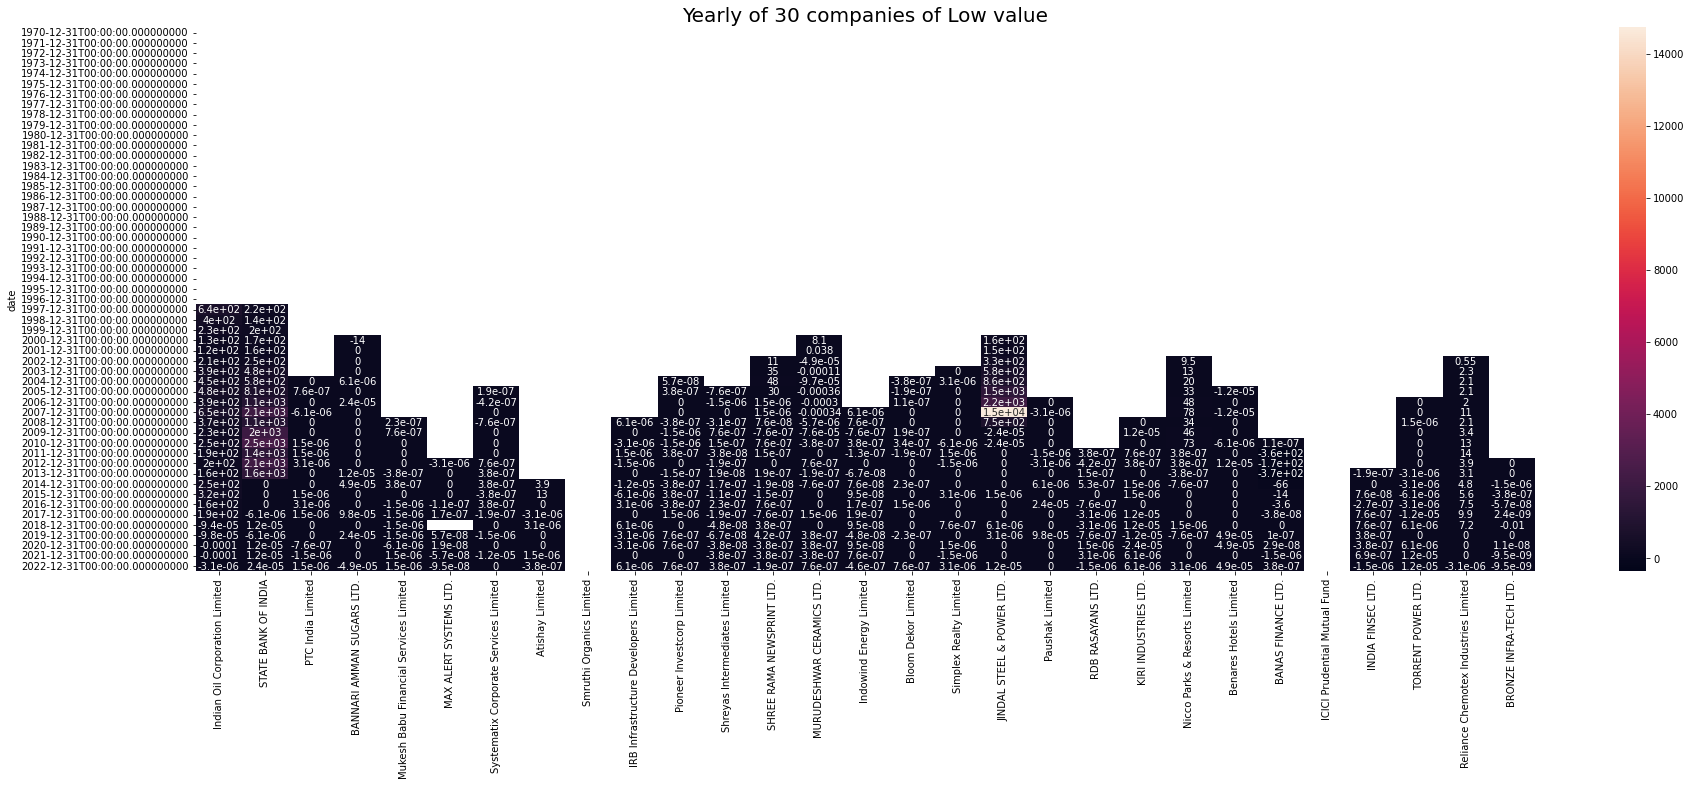

In [360]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[3] , annot = True)
plt.title('Yearly of 30 companies of Low value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Volume values

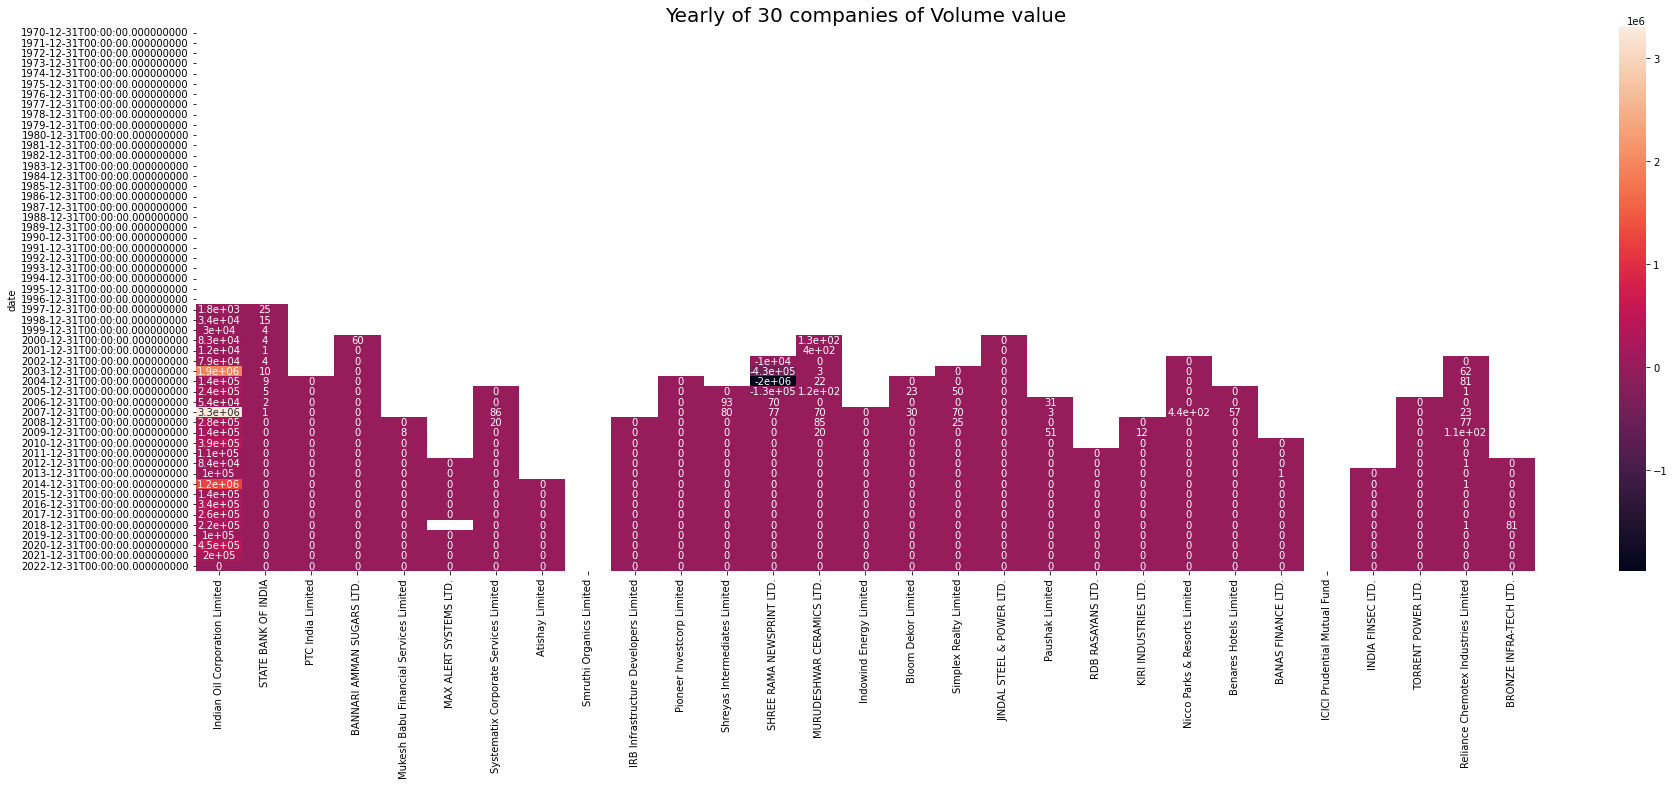

In [ ]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[5] , annot = True)
plt.title('Yearly of 30 companies of Volume value', fontdict={'fontsize':20})
plt.show()

### Exploring correlaltion among data
Here, we will explore correlation among data using correlation matrix then we will plot that on heatmap.

#### Correlation plot for open values

<AxesSubplot:>

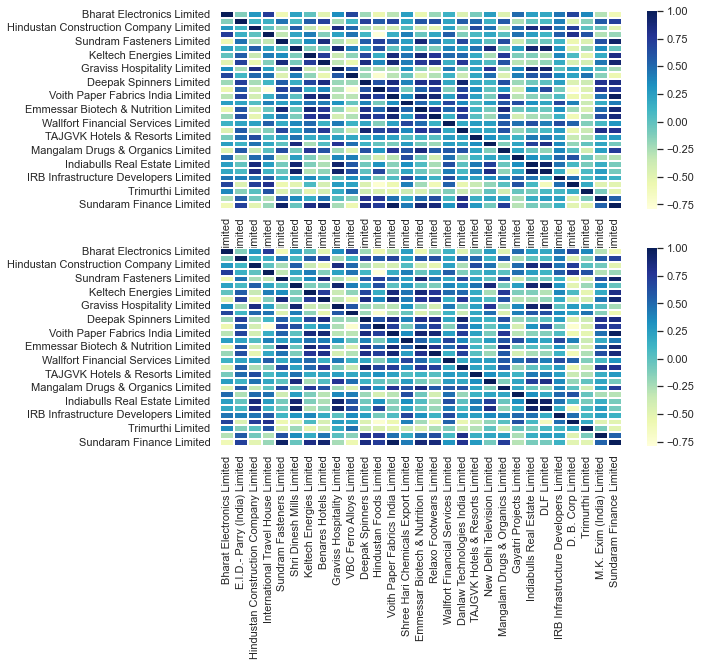

In [109]:
corrmat = eod_list[0].corr()
corrmat2 = yfinance_list[0].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for open values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for open values.')

#### Correlation plot for close values

<AxesSubplot:>

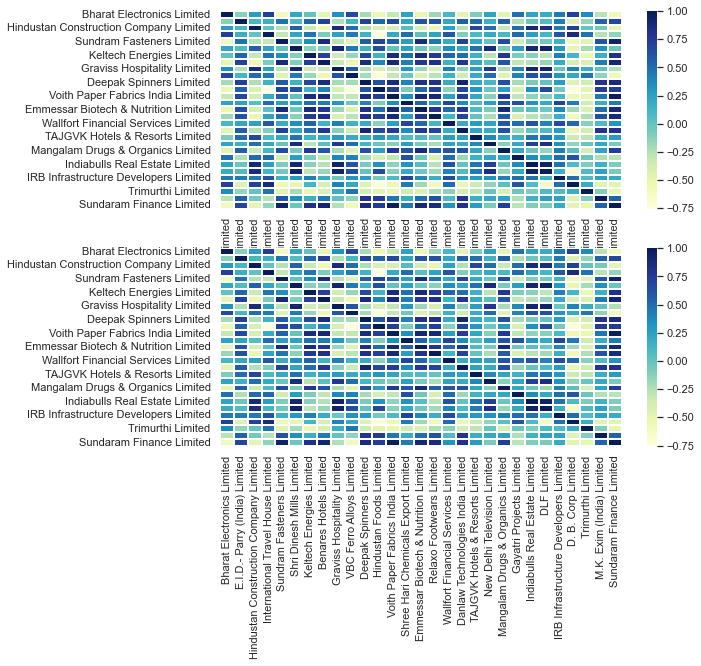

In [110]:
corrmat = eod_list[1].corr()
corrmat2 = yfinance_list[1].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for close values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for close values.')

#### Correlation plot for high values

<AxesSubplot:>

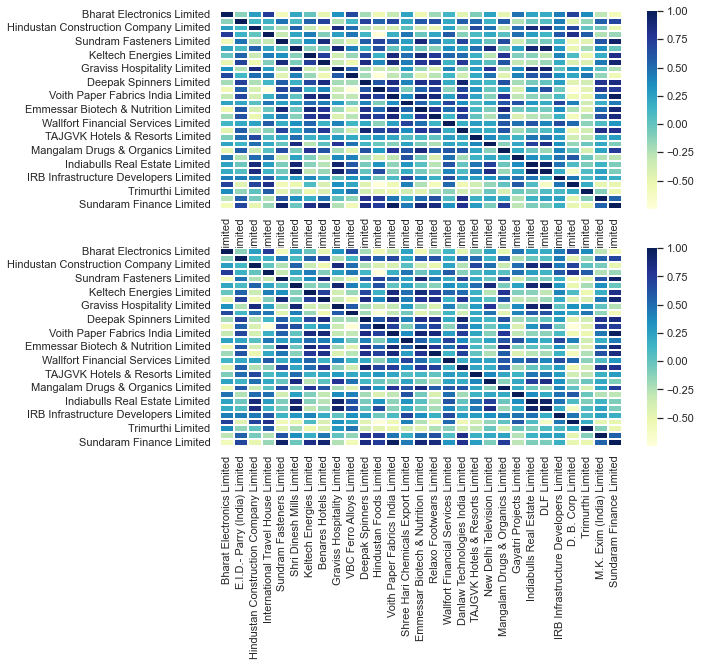

In [111]:
corrmat = eod_list[2].corr()
corrmat2 = yfinance_list[2].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for high values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for high values.')

#### Correlation plot for low values

[Text(0.5, 1.0, 'Yfinance correlation matrix for low values.')]

<Figure size 2160x720 with 0 Axes>

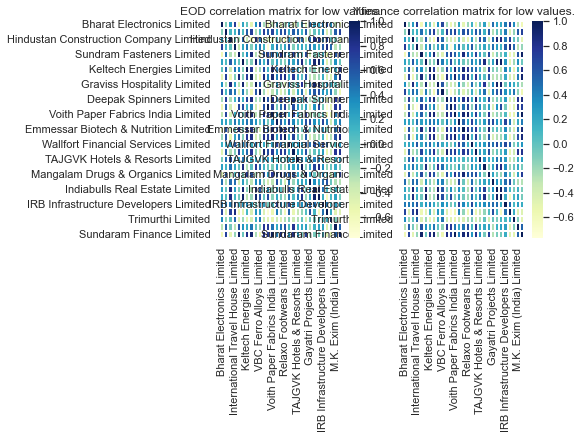

In [133]:
corrmat = eod_list[3].corr()
corrmat2 = yfinance_list[3].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for low values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for low values.')

#### Correlation plot for volume values

<Figure size 720x2160 with 0 Axes>

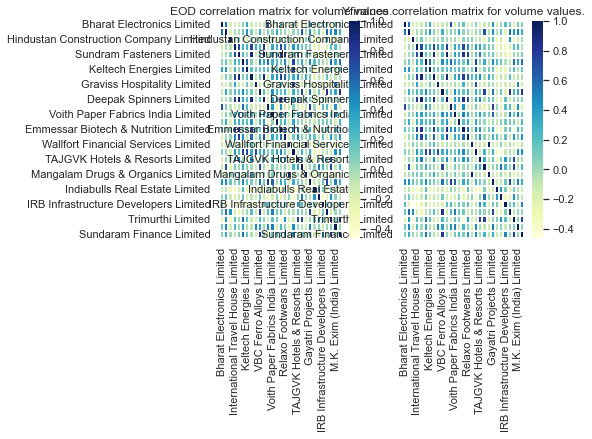

In [130]:
corrmat = eod_list[4].corr()
corrmat2 = yfinance_list[4].corr()
plt.figure(figsize=(10,30))
f, ax = plt.subplots(1,2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for volume values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for volume values.')

### Histplot
Plotting the count of NAN values of yearly calculated data of each field of different sources.

#### Open values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\584187326.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


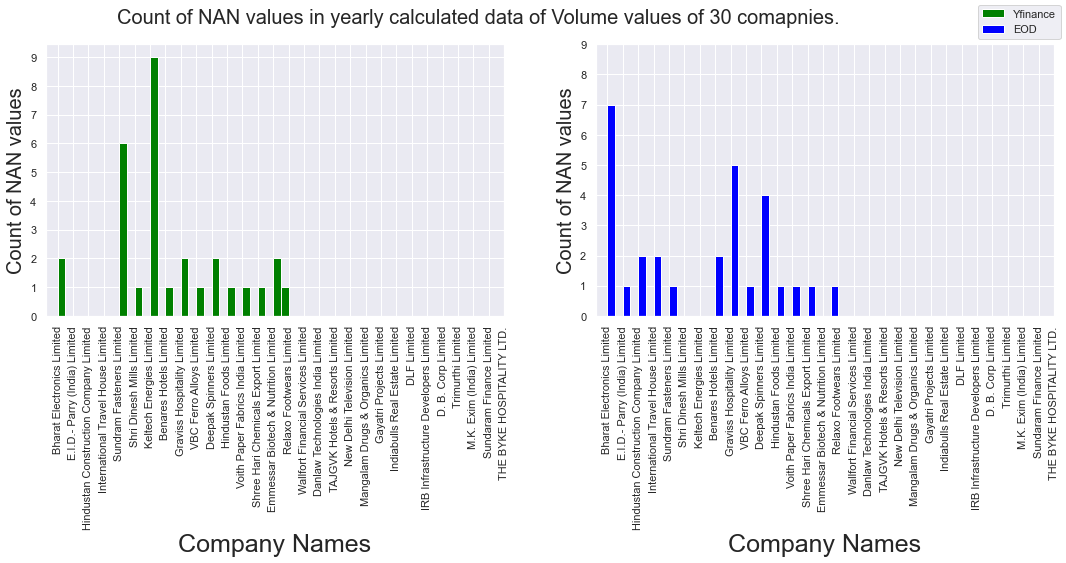

In [213]:
df = yfinance_list[0].isna().sum()
df = pd.DataFrame(df)
df1 = eod_list[0].isna().sum()
df1 = pd.DataFrame(df1)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df, color="green", bins=30)
l2 = ax2.hist(df1, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

####  Close Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\4247876057.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


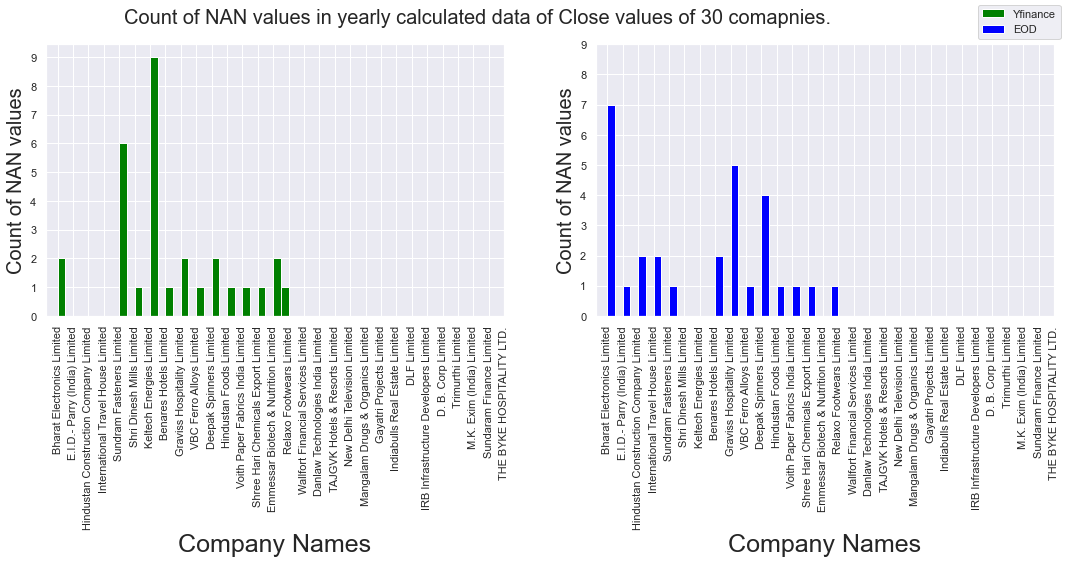

In [215]:
df3 = yfinance_list[1].isna().sum()
df3 = pd.DataFrame(df3)
df4 = eod_list[1].isna().sum()
df4 = pd.DataFrame(df4)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Close values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df3, color="green", bins=30)
l2 = ax2.hist(df4, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### High Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\1877719279.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


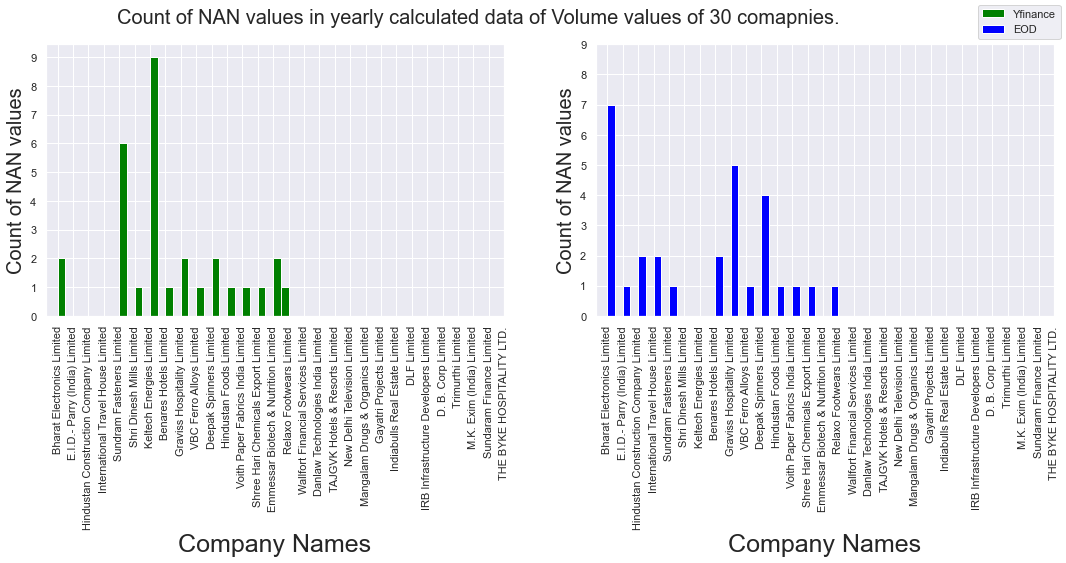

In [216]:
df5 = yfinance_list[2].isna().sum()
df5 = pd.DataFrame(df5)
df6 = eod_list[2].isna().sum()
df6 = pd.DataFrame(df6)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df5, color="green", bins=30)
l2 = ax2.hist(df6, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### Low Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\4230031498.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


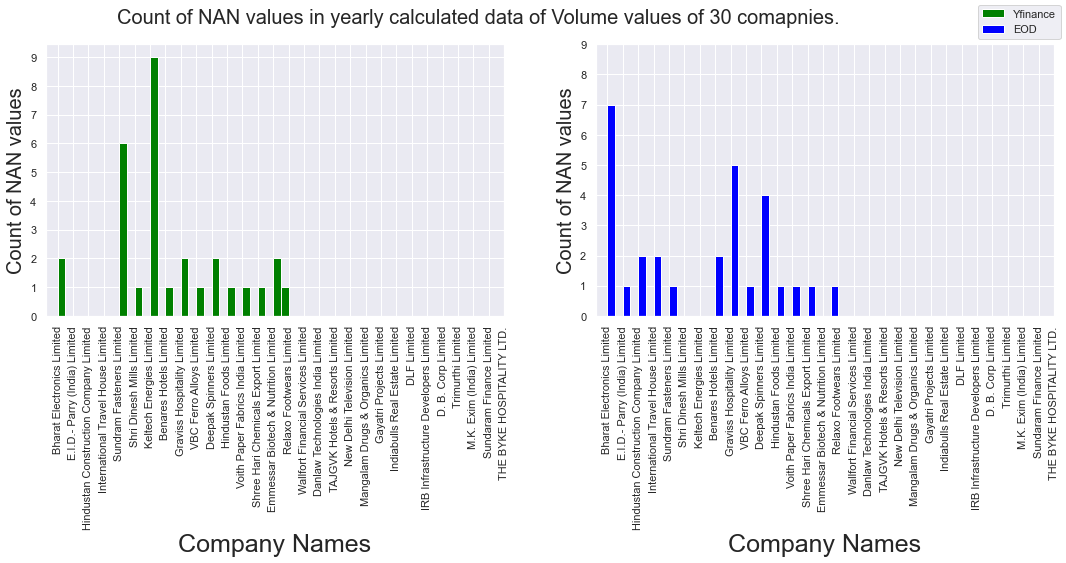

In [217]:
df7 = yfinance_list[3].isna().sum()
df7 = pd.DataFrame(df7)
df8 = eod_list[3].isna().sum()
df8 = pd.DataFrame(df8)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df7, color="green", bins=30)
l2 = ax2.hist(df8, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### Volume Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\3630915568.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


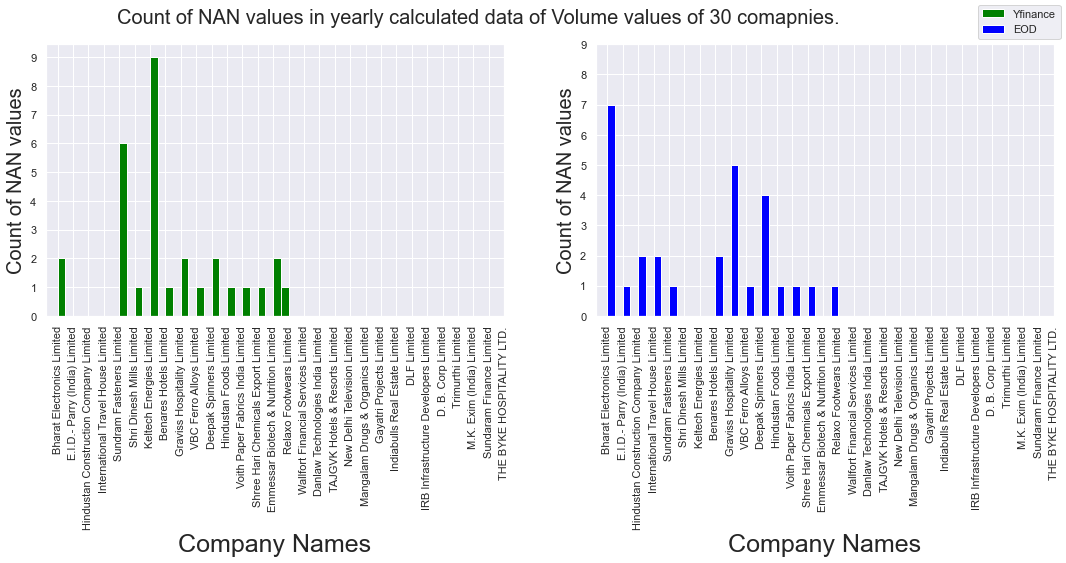

In [218]:
df9 = yfinance_list[4].isna().sum()
df9 = pd.DataFrame(df9)
df10 = eod_list[4].isna().sum()
df10 = pd.DataFrame(df10)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df9, color="green", bins=30)
l2 = ax2.hist(df10, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

# Conclusion

|yfinance|EODHistorical data|
|:---:|:---:|
|No missing values.|No missing values.|
|Contains More NAN values for yearly calculated data.|Contains NAN values for yearly calculated data.|
|No duplicate values|No duplicate values|
|Contains more outliers in volume column.|Contains outliers in volume column.|

**Eodhistorical data has slight higher values than yfinance data values.**